In [1]:
from sklearn import datasets
from sklearn.model_selection import train_test_split


# 2 classes 2-D data
X, y = datasets.make_blobs(
    n_samples=[125 * 5, 125 * 2],
    n_features=2,
    centers=[(9.5, 10), (10, 9.4)],
    cluster_std=[[0.6, 0.6], [0.35, 0.3]],
    shuffle=True
)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=43)

In [3]:
import dbc
from dbc.discretizers import *

model = dbc.DiscreteBayesianClassifier(
    discretizer=CMeansClasswiseDiscretizer(n_clusters_per_class=3, fuzzifier=1.5),
    minmax=True,
    minmax_eps = 1e-2,
    # loss_function=loss_matrix,
)
model.fit(X_train, y_train)
y_pred_train = model.predict(X_train)
conditional_risk_train = dbc.compute_class_conditional_risk_with_labels(y_train, y_pred_train)
y_pred_test = model.predict(X_test)
conditional_risk_test = dbc.compute_class_conditional_risk_with_labels(y_test, y_pred_test)
print(f'Train class condition risk: {conditional_risk_train[0]}')
print(f'Test class condition risk: {conditional_risk_test[0]}')

Train class condition risk: [0.21176471 0.21578947]
Test class condition risk: [0.22608696 0.21666667]


No class-wise Kmeans DBC train class condition risk: [0.15490196 0.28947368]
No class-wise Kmeans DBC test class condition risk: [0.1826087  0.28333333]
class-wise Kmeans DBC train class condition risk: [0.08627451 0.45263158]
class-wise Kmeans DBC test class condition risk: [0.06956522 0.46666667]
No class-wise Cmeans DBC train class condition risk: [0.08431373 0.48947368]
No class-wise Cmeans DBC test class condition risk: [0.07826087 0.45      ]
class-wise Cmeans DBC train class condition risk: [0.07058824 0.52631579]
class-wise Cmeans DBC test class condition risk: [0.07826087 0.46666667]
No class-wise Kmeans DMC train class condition risk: [0.17254902 0.3       ]
No class-wise Kmeans DMC test class condition risk: [0.15652174 0.28333333]
class-wise Kmeans DMC train class condition risk: [0.23333333 0.11052632]
class-wise Kmeans DMC test class condition risk: [0.2  0.15]
No class-wise Cmeans DMC train class condition risk: [0.19803922 0.18947368]
No class-wise Cmeans DMC test class

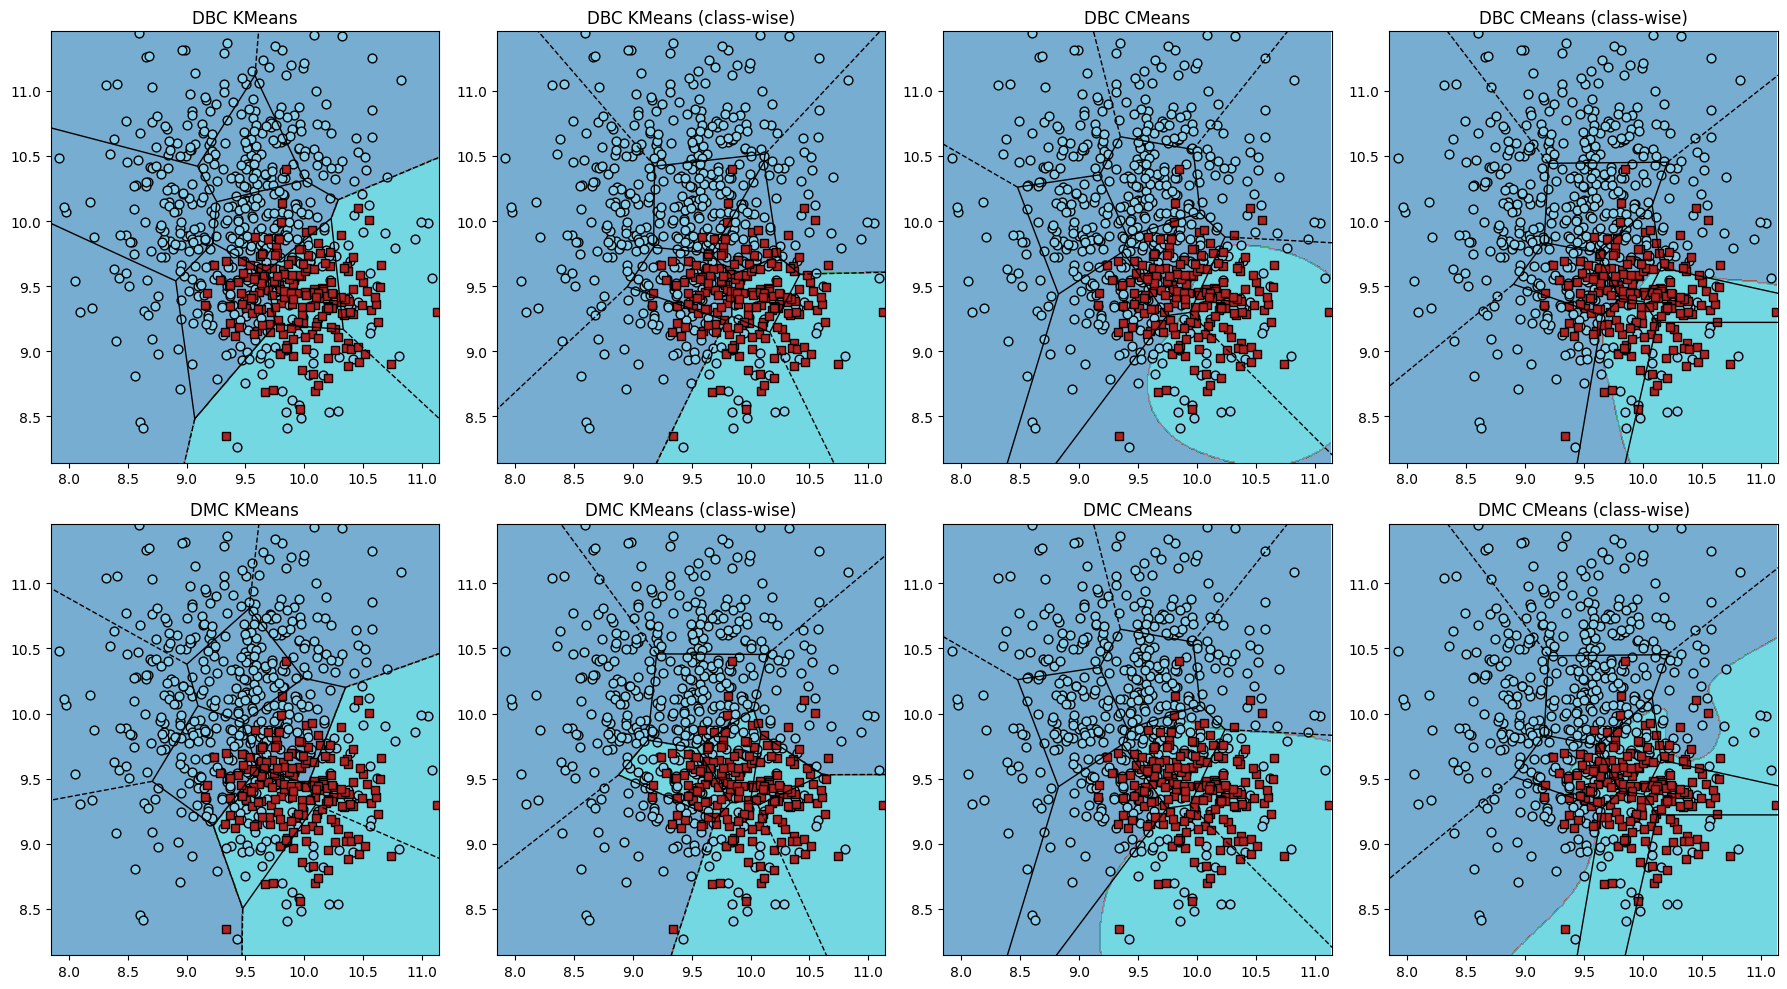

In [7]:
import dbc
from dbc.discretizers import *
from scipy.spatial import Voronoi, voronoi_plot_2d
import numpy as np
from matplotlib import pyplot as plt
# Plot the decision regions
padding = - 0.3
fuzzifier = 1.5
T_total = 10
n_clusters_per_class = 5
# No class_wise Kmeans
DBC_Kmeans = dbc.DiscreteBayesianClassifier(
    discretizer=KMeansDiscretizer(n_clusters=T_total),
)
DBC_Kmeans.fit(X_train, y_train)
# Train set pred
y_pred_train = DBC_Kmeans.predict(X_train)
conditional_risk_train = dbc.compute_class_conditional_risk_with_labels(y_train, y_pred_train)
print(f'No class-wise Kmeans DBC train class condition risk: {conditional_risk_train[0]}')
# Test set pred
y_pred_test = DBC_Kmeans.predict(X_test)
conditional_risk_test = dbc.compute_class_conditional_risk_with_labels(y_test, y_pred_test)
print(f'No class-wise Kmeans DBC test class condition risk: {conditional_risk_test[0]}')

# class_wise Kmeans
DBC_Kmeans_class_wise = dbc.DiscreteBayesianClassifier(
    discretizer=KMeansClasswiseDiscretizer(n_clusters_per_class=n_clusters_per_class),
)
DBC_Kmeans_class_wise.fit(X_train, y_train)
# Train set pred
y_pred_train = DBC_Kmeans_class_wise.predict(X_train)
conditional_risk_train = dbc.compute_class_conditional_risk_with_labels(y_train, y_pred_train)
print(f'class-wise Kmeans DBC train class condition risk: {conditional_risk_train[0]}')
# Test set pred
y_pred_test = DBC_Kmeans_class_wise.predict(X_test)
conditional_risk_test = dbc.compute_class_conditional_risk_with_labels(y_test, y_pred_test)
print(f'class-wise Kmeans DBC test class condition risk: {conditional_risk_test[0]}')

# No class_wise Cmeans
DBC_Cmeans = dbc.DiscreteBayesianClassifier(
    discretizer=CMeansDiscretizer(n_clusters=T_total, fuzzifier=fuzzifier),
)
DBC_Cmeans.fit(X_train, y_train)
# Train set pred
y_pred_train = DBC_Cmeans.predict(X_train)
conditional_risk_train = dbc.compute_class_conditional_risk_with_labels(y_train, y_pred_train)
print(f'No class-wise Cmeans DBC train class condition risk: {conditional_risk_train[0]}')
# Test set pred
y_pred_test = DBC_Cmeans.predict(X_test)
conditional_risk_test = dbc.compute_class_conditional_risk_with_labels(y_test, y_pred_test)
print(f'No class-wise Cmeans DBC test class condition risk: {conditional_risk_test[0]}')

# class_wise Cmeans
DBC_Cmeans_class_wise = dbc.DiscreteBayesianClassifier(
    discretizer=CMeansClasswiseDiscretizer(n_clusters_per_class=n_clusters_per_class, fuzzifier=fuzzifier),
)
DBC_Cmeans_class_wise.fit(X_train, y_train)
# Train set pred
y_pred_train = DBC_Cmeans_class_wise.predict(X_train)
conditional_risk_train = dbc.compute_class_conditional_risk_with_labels(y_train, y_pred_train)
print(f'class-wise Cmeans DBC train class condition risk: {conditional_risk_train[0]}')
# Test set pred
y_pred_test = DBC_Cmeans_class_wise.predict(X_test)
conditional_risk_test = dbc.compute_class_conditional_risk_with_labels(y_test, y_pred_test)
print(f'class-wise Cmeans DBC test class condition risk: {conditional_risk_test[0]}')

# No class_wise Kmeans
DMC_Kmeans = dbc.DiscreteBayesianClassifier(
    discretizer=KMeansDiscretizer(n_clusters=T_total),
)
DMC_Kmeans.fit(X_train, y_train)
# Train set pred
y_pred_train = DMC_Kmeans.predict(X_train)
conditional_risk_train = dbc.compute_class_conditional_risk_with_labels(y_train, y_pred_train)
print(f'No class-wise Kmeans DMC train class condition risk: {conditional_risk_train[0]}')
# Test set pred
y_pred_test = DMC_Kmeans.predict(X_test)
conditional_risk_test = dbc.compute_class_conditional_risk_with_labels(y_test, y_pred_test)
print(f'No class-wise Kmeans DMC test class condition risk: {conditional_risk_test[0]}')

# class_wise Kmeans
DMC_Kmeans_class_wise = dbc.DiscreteBayesianClassifier(
    discretizer=KMeansClasswiseDiscretizer(n_clusters_per_class=n_clusters_per_class),
    minmax=True,
)
DMC_Kmeans_class_wise.fit(X_train, y_train)
# Train set pred
y_pred_train = DMC_Kmeans_class_wise.predict(X_train)
conditional_risk_train = dbc.compute_class_conditional_risk_with_labels(y_train, y_pred_train)
print(f'class-wise Kmeans DMC train class condition risk: {conditional_risk_train[0]}')
# Test set pred
y_pred_test = DMC_Kmeans_class_wise.predict(X_test)
conditional_risk_test = dbc.compute_class_conditional_risk_with_labels(y_test, y_pred_test)
print(f'class-wise Kmeans DMC test class condition risk: {conditional_risk_test[0]}')

# No class_wise Cmeans
DMC_Cmeans = dbc.DiscreteBayesianClassifier(
    discretizer=CMeansDiscretizer(n_clusters=T_total, fuzzifier=fuzzifier),
    minmax=True,
)
DMC_Cmeans.fit(X_train, y_train)
# Train set pred
y_pred_train = DMC_Cmeans.predict(X_train)
conditional_risk_train = dbc.compute_class_conditional_risk_with_labels(y_train, y_pred_train)
print(f'No class-wise Cmeans DMC train class condition risk: {conditional_risk_train[0]}')
# Test set pred
y_pred_test = DMC_Cmeans.predict(X_test)
conditional_risk_test = dbc.compute_class_conditional_risk_with_labels(y_test, y_pred_test)
print(f'No class-wise Cmeans DMC test class condition risk: {conditional_risk_test[0]}')

# class_wise Cmeans
DMC_Cmeans_class_wise = dbc.DiscreteBayesianClassifier(
    discretizer=CMeansClasswiseDiscretizer(n_clusters_per_class=n_clusters_per_class, fuzzifier=fuzzifier),
    minmax=True,
)
DMC_Cmeans_class_wise.fit(X_train, y_train)
# Train set pred
y_pred_train = DMC_Cmeans_class_wise.predict(X_train)
conditional_risk_train = dbc.compute_class_conditional_risk_with_labels(y_train, y_pred_train)
print(f'class-wise Cmeans DMC train class condition risk: {conditional_risk_train[0]}')
# Test set pred
y_pred_test = DMC_Cmeans_class_wise.predict(X_test)
conditional_risk_test = dbc.compute_class_conditional_risk_with_labels(y_test, y_pred_test)
print(f'class-wise Cmeans DMC test class condition risk: {conditional_risk_test[0]}')



fig, ax = plt.subplots(2, 4, figsize=(18, 10))
x_min, x_max = X_train[:, 0].min() - padding, X_train[:, 0].max() + padding
y_min, y_max = X_train[:, 1].min() - padding, X_train[:, 1].max() + padding
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                     np.arange(y_min, y_max, 0.01))

voronoi_plot_2d(Voronoi(DBC_Kmeans.discretizer.centers_), show_points=False, show_vertices=False, s=1, ax=ax[0, 0])
voronoi_plot_2d(Voronoi(DBC_Kmeans_class_wise.discretizer.centers_), show_points=False, show_vertices=False, s=1,
                ax=ax[0, 1])
voronoi_plot_2d(Voronoi(DBC_Cmeans.discretizer.centers_), show_points=False, show_vertices=False, s=1, ax=ax[0, 2])
voronoi_plot_2d(Voronoi(DBC_Cmeans_class_wise.discretizer.centers_), show_points=False, show_vertices=False, s=1,
                ax=ax[0, 3])

voronoi_plot_2d(Voronoi(DMC_Kmeans.discretizer.centers_), show_points=False, show_vertices=False, s=1, ax=ax[1, 0])
voronoi_plot_2d(Voronoi(DMC_Kmeans_class_wise.discretizer.centers_), show_points=False, show_vertices=False, s=1,
                ax=ax[1, 1])
voronoi_plot_2d(Voronoi(DMC_Cmeans.discretizer.centers_), show_points=False, show_vertices=False, s=1, ax=ax[1, 2])
voronoi_plot_2d(Voronoi(DMC_Cmeans_class_wise.discretizer.centers_), show_points=False, show_vertices=False, s=1,
                ax=ax[1, 3])

Z_DBC_Kmeans = DBC_Kmeans.predict_prob(np.c_[xx.ravel(), yy.ravel()])
Z_DBC_Kmeans_class_wise = DBC_Kmeans_class_wise.predict_prob(np.c_[xx.ravel(), yy.ravel()])

Z_DBC_Cmeans = DBC_Cmeans.predict_prob(np.c_[xx.ravel(), yy.ravel()])
Z_DBC_Cmeans_class_wise = DBC_Cmeans_class_wise.predict_prob(np.c_[xx.ravel(), yy.ravel()])

Z_DMC_kmeans = DMC_Kmeans.predict_prob(np.c_[xx.ravel(), yy.ravel()])
Z_DMC_kmeans_class_wise = DMC_Kmeans_class_wise.predict_prob(np.c_[xx.ravel(), yy.ravel()])

Z_DMC_Cmeans = DMC_Cmeans.predict_prob(np.c_[xx.ravel(), yy.ravel()])
Z_DMC_Cmeans_class_wise = DMC_Cmeans_class_wise.predict_prob(np.c_[xx.ravel(), yy.ravel()])

Z_DBC_Kmeans_reshape = np.argmax(Z_DBC_Kmeans, axis=1).reshape(xx.shape)
Z_DBC_Kmeans_class_wise_reshape = np.argmax(Z_DBC_Kmeans_class_wise, axis=1).reshape(xx.shape)
Z_DBC_Cmeans_reshape = np.argmax(Z_DBC_Cmeans, axis=1).reshape(xx.shape)
Z_DBC_Cmeans_class_wise_reshape = np.argmax(Z_DBC_Cmeans_class_wise, axis=1).reshape(xx.shape)
Z_DMC_kmeans_reshape = np.argmax(Z_DMC_kmeans, axis=1).reshape(xx.shape)
Z_DMC_kmeans_class_wise_reshape = np.argmax(Z_DMC_kmeans_class_wise, axis=1).reshape(xx.shape)
Z_DMC_Cmeans_reshape = np.argmax(Z_DMC_Cmeans, axis=1).reshape(xx.shape)
Z_DMC_Cmeans_class_wise_reshape = np.argmax(Z_DMC_Cmeans_class_wise, axis=1).reshape(xx.shape)

contour1 = ax[0, 0].contourf(xx, yy, Z_DBC_Kmeans_reshape, cmap='tab10', alpha=0.6)
contour2 = ax[0, 1].contourf(xx, yy, Z_DBC_Kmeans_class_wise_reshape, cmap='tab10', alpha=0.6)
contour3 = ax[0, 2].contourf(xx, yy, Z_DBC_Cmeans_reshape, cmap='tab10', alpha=0.6)
contour4 = ax[0, 3].contourf(xx, yy, Z_DBC_Cmeans_class_wise_reshape, cmap='tab10', alpha=0.6)
contour5 = ax[1, 0].contourf(xx, yy, Z_DMC_kmeans_reshape, cmap='tab10', alpha=0.6)
contour6 = ax[1, 1].contourf(xx, yy, Z_DMC_kmeans_class_wise_reshape, cmap='tab10', alpha=0.6)
contour7 = ax[1, 2].contourf(xx, yy, Z_DMC_Cmeans_reshape, cmap='tab10', alpha=0.6)
contour8 = ax[1, 3].contourf(xx, yy, Z_DMC_Cmeans_class_wise_reshape, cmap='tab10', alpha=0.6)

# colors for each class
colors = ['skyblue', 'firebrick', 'forestgreen']
markers = ['o', 's', '^']  # circle, square, triangle

# Iterate over all axes and plot training data on each subplot
for row in range(2):
    for col in range(4):
        ax[row, col].set_xlim(x_min, x_max)
        ax[row, col].set_ylim(y_min, y_max)
        ax_current = ax[row, col]
        for i, (c, m) in enumerate(zip(colors, markers)):
            ax_current.scatter(
                X_train[y_train == i, 0],
                X_train[y_train == i, 1],
                color=c,
                edgecolor='k',
                marker=m,
                s=40,
                label=f'Class {i}'
            )

# Set titles for each subplot
titles = [
    "DBC KMeans", "DBC KMeans (class-wise)", "DBC CMeans", "DBC CMeans (class-wise)",
    "DMC KMeans", "DMC KMeans (class-wise)", "DMC CMeans", "DMC CMeans (class-wise)"
]
for ax_i, title in zip(ax.flat, titles):
    ax_i.set_title(title)

# Optional: add colorbar for consistency
# plt.colorbar(contour2, ax=ax.ravel().tolist(), ticks=[0, 1, 2], label='Predicted class')

plt.tight_layout()
plt.show()
